## The Data

-----------

ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches. **

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

**TRIPLE CHECK WHERE YOUR FILES ARE DOWNLOADED AND UNZIPPED. PLEASE REVIEW VIDEO BEFORE POSTING TO QA FORUMS.**

In [5]:
my_data_dir = '../../cell_images'

In [7]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [8]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [9]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [10]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [11]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [12]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [13]:
para_img= imread(para_cell)

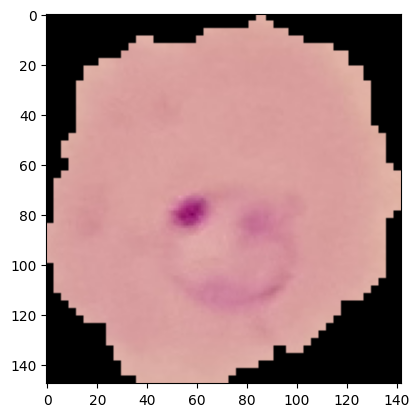

In [14]:
plt.imshow(para_img)

In [15]:
para_img.shape

(148, 142, 3)

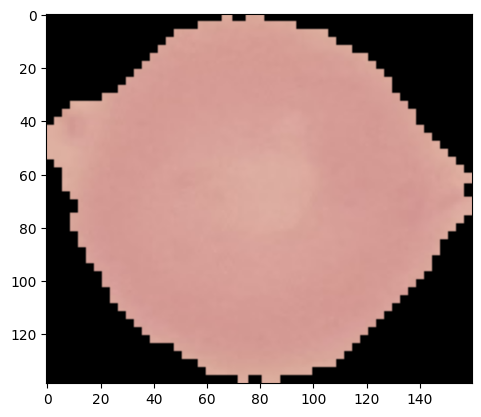

In [16]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Let's check how many images there are.**

In [17]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [18]:
len(os.listdir(train_path+'\\uninfected'))

12480

**Let's find out the average dimensions of these images.**

In [19]:
unifected_cell.shape

(139, 160, 3)

In [20]:
para_img.shape

(148, 142, 3)

In [21]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

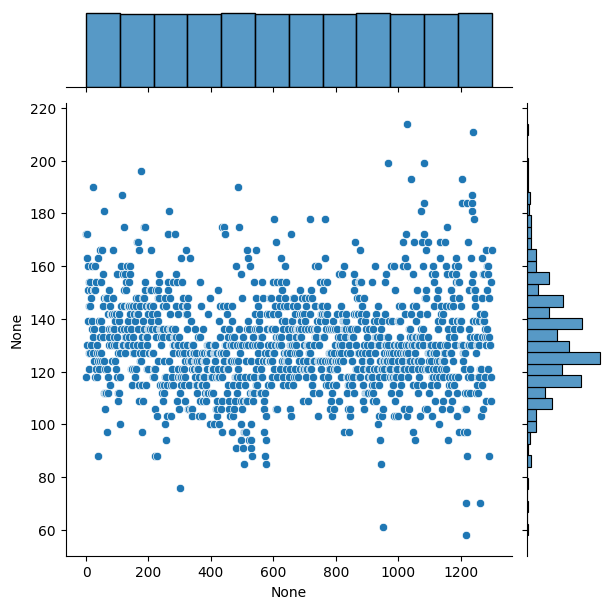

In [24]:
# sns.jointplot(dim1,dim2)
sns.jointplot(dim1)

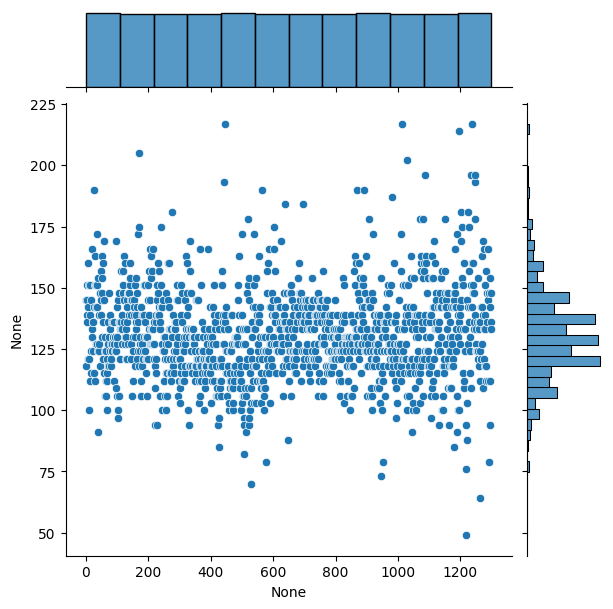

In [25]:
sns.jointplot(dim2)

In [26]:
np.mean(dim1)

130.92538461538462

In [27]:
np.mean(dim2)

130.75

In [28]:
image_shape = (130,130,3)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

In [32]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

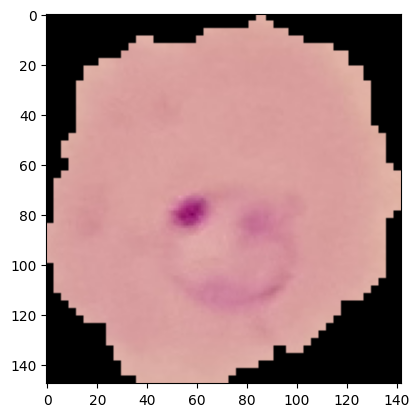

In [33]:
plt.imshow(para_img)

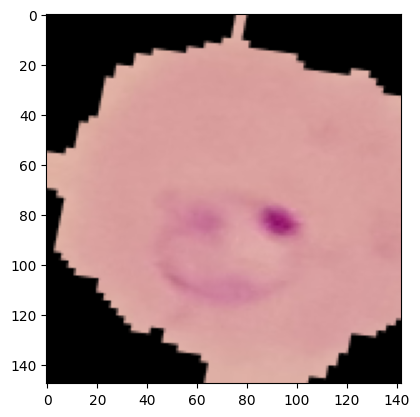

In [34]:
plt.imshow(image_gen.random_transform(para_img))

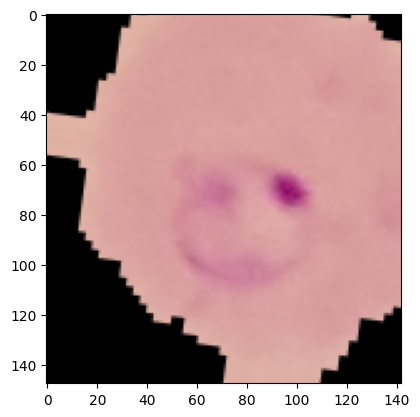

In [35]:
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [36]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [37]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [39]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

## Early Stopping

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [43]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.src.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.src.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain
          one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
          inside each of the subdirectories directory tree will be included
          in the generator. See [this script](
          https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The di

In [44]:
batch_size = 16

In [45]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [46]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [47]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 605s 387ms/step - loss: 0.4309 - accuracy: 0.7997 - val_loss: 0.2115 - val_accuracy: 0.9131
Epoch 2/20
1560/1560 [==============================] - 384s 246ms/step - loss: 0.1961 - accuracy: 0.9341 - val_loss: 0.1886 - val_accuracy: 0.9250
Epoch 3/20
1560/1560 [==============================] - 354s 227ms/step - loss: 0.1731 - accuracy: 0.9465 - val_loss: 0.1625 - val_accuracy: 0.9469
Epoch 4/20
1560/1560 [==============================] - 406s 260ms/step - loss: 0.1659 - accuracy: 0.9487 - val_loss: 0.1549 - val_accuracy: 0.9446
Epoch 5/20
1560/1560 [==============================] - 544s 349ms/step - loss: 0.1614 - accuracy: 0.9500 - val_loss: 0.1582 - val_accuracy: 0.9481
Epoch 6/20
1560/1560 [==============================] - 415s 266ms/step - loss: 0.1561 - accuracy: 0.9503 - val_loss: 0.1492 - val_accuracy: 0.9542
Epoch 7/20
1560/1560 [==============================] - 425s 272ms/step - loss: 0.1516 - accuracy: 0.9520 - val_

In [50]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

# Evaluating the Model

In [51]:
losses = pd.DataFrame(model.history.history)

<Axes: >

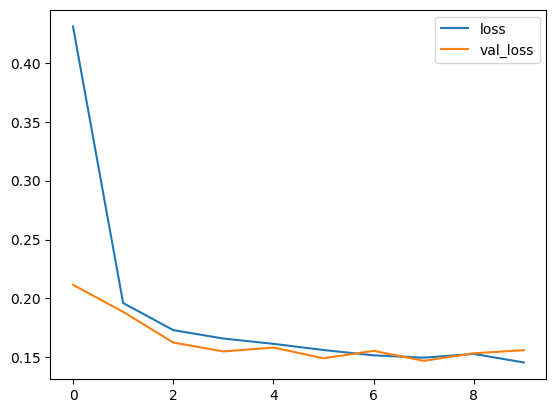

In [52]:
losses[['loss','val_loss']].plot()

In [53]:
model.metrics_names

['loss', 'accuracy']

In [54]:
model.evaluate_generator(test_image_gen)

[0.1557902693748474, 0.9442307949066162]

In [55]:
from tensorflow.keras.preprocessing import image

In [56]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [57]:
pred_probabilities

array([[1.9343954e-04],
       [3.7837017e-04],
       [4.8450322e-05],
       ...,
       [9.5210391e-01],
       [9.7360104e-01],
       [9.1848469e-01]], dtype=float32)

In [58]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [59]:
predictions = pred_probabilities > 0.5

In [60]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [61]:
from sklearn.metrics import classification_report,confusion_matrix

In [62]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1300
           1       0.94      0.95      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [63]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1223,   77],
       [  67, 1233]], dtype=int64)

# Predicting on an Image

In [64]:
# Your file path will be different!
para_cell

'../../cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [65]:
my_image = image.load_img(para_cell,target_size=image_shape)

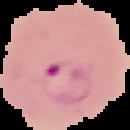

In [66]:
my_image

In [67]:
type(my_image)

PIL.Image.Image

In [68]:
my_image = image.img_to_array(my_image)

In [69]:
type(my_image)

numpy.ndarray

In [70]:
my_image.shape

(130, 130, 3)

In [71]:
my_image = np.expand_dims(my_image, axis=0)

In [72]:
my_image.shape

(1, 130, 130, 3)

In [73]:
model.predict(my_image)

1/1 [==============================] - 0s 127ms/step


array([[0.]], dtype=float32)

In [74]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [75]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

# Great Job!